![logo.JPG](data/img/logo.JPG)
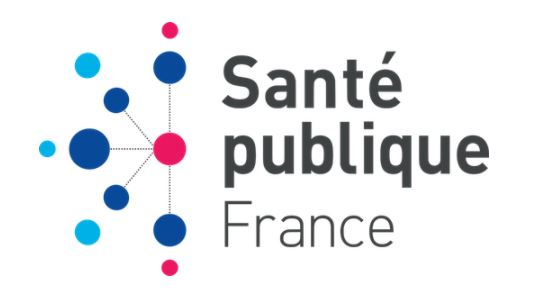

In [30]:
# Importation des librairies python spécialisées dans le Jupyter Notebook
import pandas as pd
import numpy as np
import missingno as msno

In [31]:
# Affiche la taille du jeu de données
def displayDataShape(data):
    shape = data.shape
    print(f"Le jeu de données contient : {shape[0]} lignes et {shape[1]} colonnes\n")

# Affichage des Nan en %
def displayNanPercent(data):
    missing_values = pd.DataFrame((data.isna().mean()*100).sort_values())
    missing_values.columns = ['Valeurs manquantes en %']
    return missing_values

# Retourne le data en filtrant par % de NaN dans les colonnes
def filterDataColumnByNan(data, limit_nan=0.75):
    if type(data) != type(pd.DataFrame()):
        raise ValueError(f"data n\'est pas un DataFrame, mais est de type {type(data)}!")

    return data[data.columns[data.isna().mean() <= limit_nan]].copy()

# Retourne le data en filtrant par % de Nan dans les lignes, filtré par colonnes contenant la mention "_100g" (quantité d'un nutriment pour 100g du produit)
def filterDataRowByNan(data, limit_nan=1):
    if type(data) != type(pd.DataFrame()):
        raise ValueError(f"data n\'est pas un DataFrame, mais est de type {type(data)}!")

    nutriment_amount_tag = "_100g"
    data_columns_filtered = data[[col for col in data.columns if col.endswith(nutriment_amount_tag)]]
    index_with_nan = data_columns_filtered.index[data_columns_filtered.isnull().mean(axis=1) == limit_nan]

    return data.drop(index=index_with_nan).copy()

# Retourne le data en filtrant les lignes qui ont des valeurs à NaN dans la colonne passée en paramètre
def filterDataRowByNanInColumn(data, column_name):
    if type(data) != type(pd.DataFrame()):
        raise ValueError(f"data n\'est pas un DataFrame, mais est de type {type(data)}!")

    return data[data[column_name].notna()].copy()

# Affiche le nombre de valeurs uniques pour chaque colonne dans le tableau passé en paramètres
def displayNbrUnique(data, columns):
    if type(data) != type(pd.DataFrame()):
        raise ValueError(f"data n\'est pas un DataFrame, mais est de type {type(data)}!")

    nbr_uniques = []

    for column in columns:
        nbr_uniques.append(data[column].nunique())

    return pd.Series(nbr_uniques, index=columns)

# Retourne 2 tableaux contenant les noms des colonnes des valeurs quantitatives et des valeurs qualitatives
def categoriseVariables(data):
    infos_type = data.dtypes
    quantitative_columns = []
    qualitative_columns = []

    for index in infos_type.index:
        if (infos_type[index] == 'float') | (infos_type[index] == 'int'):
            quantitative_columns.append(index)
        else:
            qualitative_columns.append(index)

    return quantitative_columns, qualitative_columns

# Affiche les informations supprimées entre le data et le data nettoyé
def displayInfosDataCleaned(data, data_cleaned):
    print(f"Nombre de lignes supprimées : {data.shape[0] - data_cleaned.shape[0]}")
    print(f"Nombre de colonnes supprimées : {data.shape[1] - data_cleaned.shape[1]}")
    print(f"Colonnes supprimées : {[col for col in data.columns if col not in data_cleaned.columns]}\n")
    displayDataShape(data_cleaned)

In [32]:
data = pd.read_csv("data/fr.openfoodfacts.org.products.csv", sep='\t', low_memory=False)
displayDataShape(data)

Le jeu de données contient : 320772 lignes et 162 colonnes



In [33]:
data_cleaned = filterDataColumnByNan(data)

In [34]:
data_cleaned = filterDataRowByNan(data_cleaned)

In [35]:
data_cleaned = filterDataRowByNanInColumn(data_cleaned, 'code')

In [36]:
displayInfosDataCleaned(data, data_cleaned)

Nombre de lignes supprimées : 57955
Nombre de colonnes supprimées : 112
Colonnes supprimées : ['generic_name', 'packaging', 'packaging_tags', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'no_nutriments', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'image_url', 'image_small_url', 'energy-from-fat_100g', 'butyric-acid_100g', 'caproic-acid_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'montanic-acid_100g', 'melissic-acid_100g', 'monounsatura

In [37]:
data_cleaned[data_cleaned.duplicated(['code','product_name'])].sort_values('code')

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,brands,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g


<AxesSubplot:>

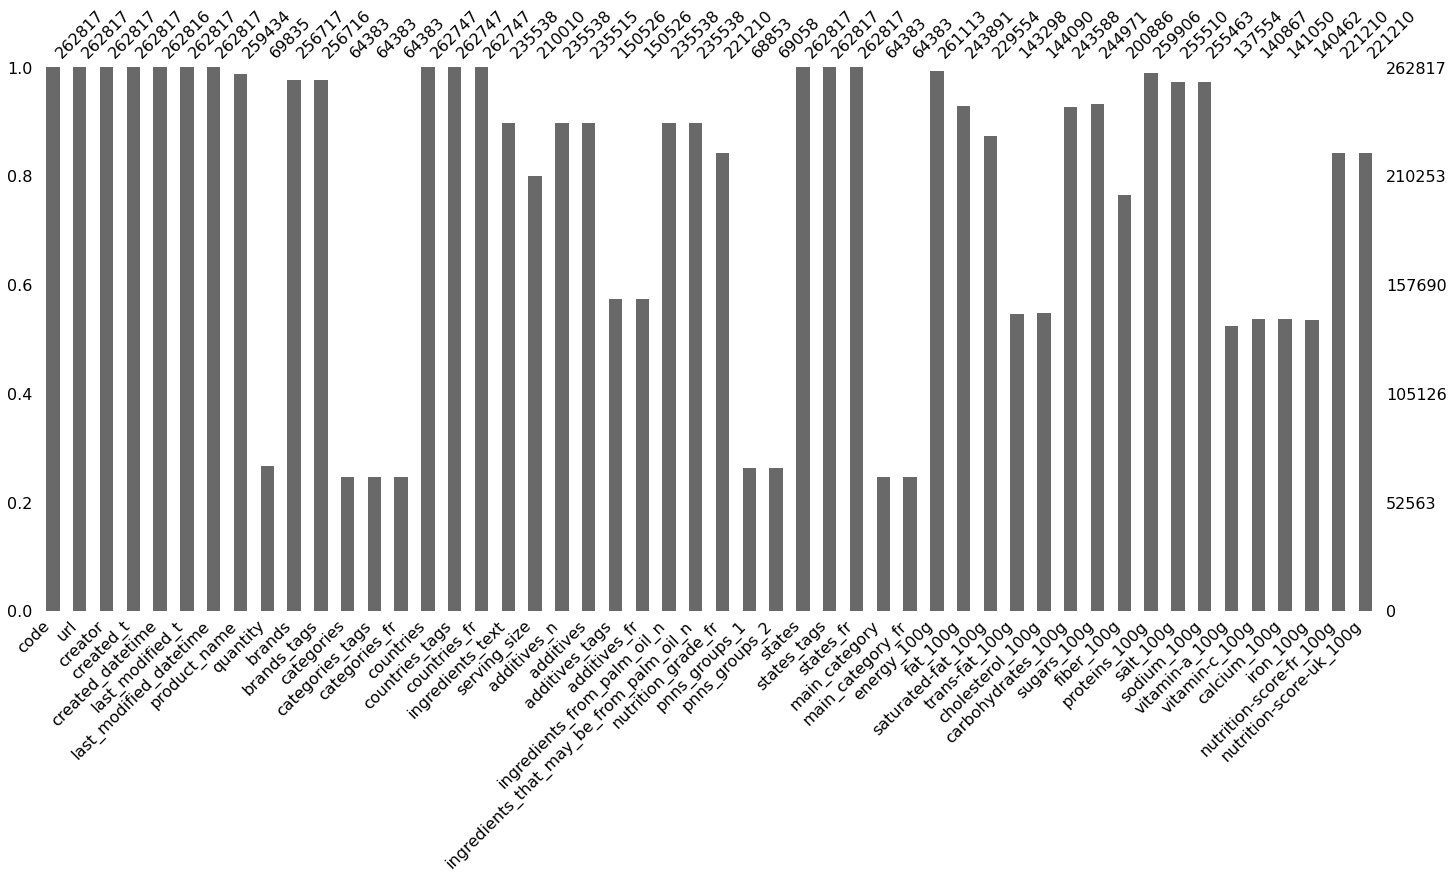

In [38]:
msno.bar(data_cleaned)

In [39]:
data_cleaned.head(20)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,brands,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,3.6,3.57,0.00000,0.000,0.000000,0.0214,0.000,0.00129,14.0,14.0
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,Torn & Glasser,...,7.1,17.86,0.63500,0.250,0.000000,0.0000,0.071,0.00129,0.0,0.0
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,Grizzlies,...,7.1,17.86,1.22428,0.482,NaN,NaN,0.143,0.00514,12.0,12.0
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,Bob's Red Mill,...,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0000000016100,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055651,2017-03-09T10:34:11Z,1489055651,2017-03-09T10:34:11Z,Breadshop Honey Gone Nuts Granola,NaN,Unfi,...,7.7,13.46,NaN,NaN,NaN,NaN,0.038,0.00346,NaN,NaN
6,0000000016117,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055730,2017-03-09T10:35:30Z,1489055730,2017-03-09T10:35:30Z,Organic Long Grain White Rice,NaN,Lundberg,...,NaN,8.89,NaN,NaN,NaN,0.0027,0.044,NaN,NaN,NaN
7,0000000016124,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055711,2017-03-09T10:35:11Z,1489055712,2017-03-09T10:35:12Z,Organic Muesli,NaN,Daddy's Muesli,...,9.4,14.06,0.13970,0.055,NaN,NaN,0.062,0.00422,7.0,7.0
8,0000000016193,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055651,2017-03-09T10:34:11Z,1489055651,2017-03-09T10:34:11Z,Organic Dark Chocolate Minis,NaN,Equal Exchange,...,7.5,5.00,NaN,NaN,NaN,NaN,0.050,0.01125,NaN,NaN
9,0000000016513,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055654,2017-03-09T10:34:14Z,1489055654,2017-03-09T10:34:14Z,Organic Sunflower Oil,NaN,Napa Valley Naturals,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0000000016612,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Adzuki Beans,NaN,Unfi,...,12.5,22.92,NaN,NaN,NaN,NaN,0.062,0.00450,NaN,NaN


In [40]:
data_cleaned.code.nunique()

262817

In [41]:
quanti,quali = categoriseVariables(data_cleaned)

In [42]:
displayNbrUnique(data_cleaned, quali)

code                      262817
url                       262817
creator                     2528
created_t                 132929
created_datetime          132928
last_modified_t           126164
last_modified_datetime    126164
product_name              187506
quantity                    9872
brands                     46573
brands_tags                40989
categories                 28761
categories_tags            16571
categories_fr              16571
countries                   1039
countries_tags               557
countries_fr                 557
ingredients_text          194351
serving_size               25232
additives                 185916
additives_tags             40152
additives_fr               40152
nutrition_grade_fr             5
pnns_groups_1                 14
pnns_groups_2                 42
states                       547
states_tags                  547
states_fr                    547
main_category               2390
main_category_fr            2390
dtype: int